This script runs a rolling weekly-window SARIMA model on the isoprene data.

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import random
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [ ]:
def bair_data_read_in(site_dir:str):
    df_lst = []
    for file in os.listdir(site_dir):
        try:
            df = pd.read_csv(rf'{site_dir}/{file}', header=1)
            df['time'] = pd.to_datetime(df['time'], unit='s')
            df['time'] = df['time'].dt.round('min')
            df_lst.append(df)
        except:
            pass
    data = pd.concat(df_lst)
    data = data.sort_values('time')
    try:
        data = data.rename(columns={'wsp_avg_ms': 'wsp', 'wdr_avg': 'wdr'})
    except AttributeError:
        pass
    if 'met' in site_dir:
        data = data[['time', 'wsp', 'wdr', 'temp_f']]
    else:
        data = data[['time', 'isoprene']]
    return data

In [ ]:
isoprene = bair_data_read_in(r'/Users/gabegreenberg/Boulder_AIR/BoulderAIR_data/LUR/voc')
print(isoprene)

                    time  isoprene
0    2020-02-01 00:42:00   0.01731
1    2020-02-01 02:06:00   0.01313
2    2020-02-01 03:31:00   0.01731
3    2020-02-01 04:55:00   0.01851
4    2020-02-01 06:20:00   0.01373
...                  ...       ...
1023 2025-02-19 00:05:00   0.00504
1024 2025-02-19 01:05:00   0.00504
1025 2025-02-19 02:05:00   0.00504
1026 2025-02-19 03:05:00   0.00504
1027 2025-02-19 04:05:00   0.00504

[40055 rows x 2 columns]


In [ ]:
# making sure the data set is continious with not gaps using imptation for SARIMA modeling
isoprene['time'] = isoprene['time'].dt.round('H')
isoprene.set_index('time', inplace=True)
isoprene = isoprene.resample('H').mean()
isoprene['isoprene'] = isoprene['isoprene'].interpolate(method='linear') 
hourly_isoprene = isoprene.reset_index()
data = hourly_isoprene[(hourly_isoprene['time'] >= "2024-06-01") & (hourly_isoprene['time'] <= "2024-10-01")]
# setting the data to just a four month window during peak isorpene season (for a single year) to reduce computatational load

/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_32759/3809115645.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  isoprene['time'] = isoprene['time'].dt.round('H')
/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_32759/3809115645.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  isoprene = isoprene.resample('H').mean()


In [ ]:
random.seed(8)

#getting possible start times for weekly intervals
start_time = data['time'].min()
end_time = data['time'].max()
latest_start_time = end_time - pd.Timedelta(days=7)
week_start_times = list(pd.date_range(start=start_time, end=latest_start_time, freq='H'))


def adf_test_func(df):
    ''' 
    extracts the relivant adf test stats
    
    Args: 
        df:  a dataframe with isoprene column (will be a randomly selected week of data)
    
    Returns:
        the relivant adf stats (adf statistic, p-value, and 5% critical value)
    '''
    adf_result = adfuller(df['isoprene'])
    return adf_result[0], adf_result[1], adf_result[4]['5%']  

def weekly_bootstrap_func(start_times, n_iterations = 50):
    ''' 
    computes a averaged stitistics of weekly isoprene to check for stationarity

        Args:
            start_times: a list of possible start times avalibe in the dataset
            n_iterations: the number of weekly intervals selected and included in the statistical averages
        
        Returns:
            None it just prints out the bootstrapped statistics to estimate an honest assesment of weither or not using weekly data meets stationarity requirments for SARIMA modeling
    '''

    n_iterations = n_iterations
    adf_stats_lst = []
    p_values_lst = []
    critical_values_lst = []

    # ranodmly selecting each week and calcualting stats (after a time is selected it's removed) for 50 itterations (by default)
    for ii in range(n_iterations):
        start_date = random.choice(start_times)
        start_times.remove(start_date)
        end_date = start_date + pd.Timedelta(weeks=1)
        week_data = data[(data['time'] >= start_date) & (data['time'] < end_date)]
        adf_stat, p_value, critical_value = adf_test_func(week_data)
        adf_stats_lst.append(adf_stat)
        p_values_lst.append(p_value)
        critical_values_lst.append(critical_value)

    mean_adf_stat = np.mean(adf_stats_lst)
    mean_p_value = np.mean(p_values_lst)
    mean_critical_value = np.mean(critical_values_lst)

    print('Average ADF Stat:', mean_adf_stat)
    print('Averag p-value:', mean_p_value)
    print('Average Critical Value (5% level):', mean_critical_value)

weekly_bootstrap_func(week_start_times)



2761
Average ADF Stat: -5.451880381928606
Average p-value: 0.0015775647798321009
Average Critical Value (5% level): -2.879384239927811
2711


In [ ]:
# suppressing warnings because not all models converge and it prints out too much obscuring the progress bar
warnings.filterwarnings("ignore") 
current_start = data['time'].iloc[0]
prediction_list = []
itter_num = 0
total_itterations = len(data) - (24 * 7)
data = data.set_index(data['time'])

for ii in range(total_itterations):
    current_end = current_start + pd.Timedelta(weeks=1)
    week_data = data[(data.index >= current_start) & (data.index < current_end)]

    #I referenced this: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
    sarima_model = SARIMAX(week_data['isoprene'], 
                       order=(1,1,1),    
                       seasonal_order=(1,1,1,24),  
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

    sarima_fit = sarima_model.fit()
    forecast = sarima_fit.forecast(steps=24)
    prediction = forecast.iloc[-1]
    # 1/2 the lower detection limit of the GC (isoprene mesuring instrument is 0.00504) which is boulder AIRs standard imputation value)
    # this just ensures predicted values less than 1/2 the LDL are repalced
    if prediction < 0.00504:
        prediction = 0.00504
    prediction_list.append(prediction)
    
    current_start = current_start + pd.Timedelta(hours=1)
    itter_num += 1
    
    # progress bar because this takes a long time
    progress_percentage = (itter_num / total_itterations) * 100
    print(f'Progress: {progress_percentage:.2f}%')



2761
2761
[np.float64(0.38091309469713), np.float64(0.4693768788726702), np.float64(0.9592024591506576), np.float64(0.46701130330820406), np.float64(0.22287831518724), np.float64(0.07945412814940159), np.float64(0.08066059138463538), np.float64(0.06957075999201519), np.float64(0.12402291720514572), np.float64(0.08783638271486219), np.float64(0.06295370035271391), np.float64(0.05256738118255025), np.float64(0.05457590132443363), np.float64(0.08920618054303973), np.float64(0.1676479824200227), np.float64(0.21050132332206145), np.float64(0.19452698813151653), np.float64(0.07334327006605051), np.float64(0.21718079633016113), np.float64(0.6344657331199444), np.float64(0.1786511393963287), np.float64(0.07263371063526197), np.float64(0.18750279340637727), np.float64(0.3494720525686345), np.float64(0.36140994579917535), np.float64(0.40331532301336254), np.float64(0.2900597308051978), np.float64(0.12153280290342683), np.float64(0.03105996246656225), 0.00504, 0.00504, 0.00504, 0.00504, 0.00504, 

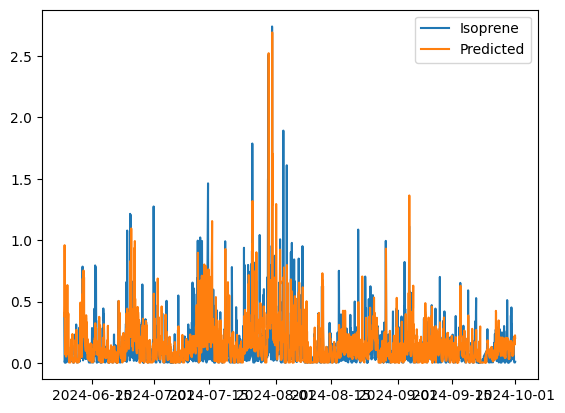

In [ ]:
df = data[(data['time'] >= "2024-06-08") & (data['time'] <= "2024-10-01")]

print(len(df))
print(len(prediction_list))

print(prediction_list)
plt.plot(df['time'], df['isoprene'], label='Isoprene')
plt.plot(df['time'], prediction_list, label='Predicted')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(np.mean((df['isoprene'] - prediction_list) ** 2))
print("RMSE:", rmse)
print(np.mean(df['isoprene']))


RMSE: 0.20142694693823968
0.1231273571169866


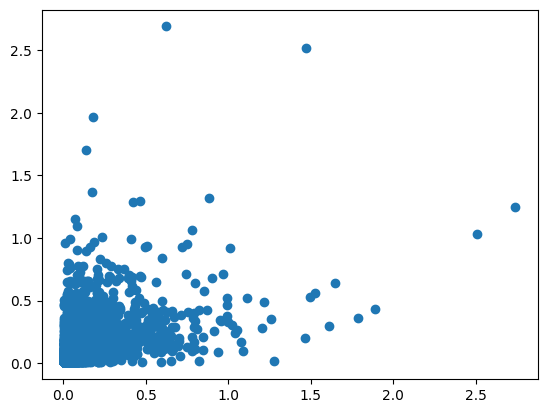

In [ ]:
plt.scatter(df['isoprene'], prediction_list)
plt.show()

In [ ]:
df['pred'] = prediction_list
df.to_csv(r'/Users/gabegreenberg/Documents/UW/ds_785_capstone/data_out/SARIMA_out.csv', index=False)